# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python.

## Setup

We first import the LensKit components we need:

In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

And Pandas is very useful:

In [2]:
import pandas as pd

In [3]:
%matplotlib inline

## Loading Data

We're going to use the ML-100K data set:

In [4]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t',
                      names=['user', 'item', 'rating', 'timestamp'])
ratings.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Defining Algorithms

Let's set up two algorithms:

In [5]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

We will first define a function to generate recommendations from one algorithm over a single partition of the data set.  It will take an algorithm, a train set, and a test set, and return the recommendations.

**Note:** before fitting the algorithm, we clone it.  Some algorithms misbehave when fit multiple times.

**Note 2:** our algorithms do not necessarily implement the `Recommend` interface, so we adapt them. This fills in a default candidate selector.

The code function looks like this:

In [6]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [7]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

With the results in place, we can concatenate them into a single data frame:

In [8]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,285,4.543364,5,1,ItemItem
1,1449,4.532999,5,2,ItemItem
2,1251,4.494639,5,3,ItemItem
3,114,4.479512,5,4,ItemItem
4,166,4.399639,5,5,ItemItem


To compute our analysis, we also need to concatenate the test data into a single frame:

In [9]:
test_data = pd.concat(test_data, ignore_index=True)

We analyze our recommendation lists with a `RecListAnalysis`.  It takes care of the hard work of making sure that the truth data (our test data) and the recoommendations line up properly.

We do assume here that each user only appears once per algorithm. Since our crossfold method partitions users, this is fine.

In [10]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

/home/MICHAELEKSTRAND/anaconda3/envs/lkpy-dev/lib/python3.7/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


ndcg
user Algorithm          
1    ALS        0.265268
     ItemItem   0.259708
2    ALS        0.148335
     ItemItem   0.081890
3    ALS        0.026615

Now we have nDCG values!

In [11]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.139689
ItemItem    0.102075
Name: ndcg, dtype: float64

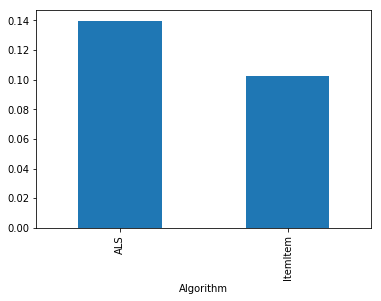

In [12]:
results.groupby('Algorithm').ndcg.mean().plot.bar()